# Optimisation Analysis of Accessible Bus Stop Locations for the London Underground Based on the P-Median Model

## Project Overview

This project aims to provide scientific recommendations for bus stop locations to meet the accessible travel needs of the London Underground system through a data-driven approach. We used the P-median facility location model, based on real travel data and geographic network information, to provide the most optimal solution for the convenience of people with disabilities. 

## 1. Data Processing and Matching

### Data Sources
- **TfL NUMBAT 2023 Data**: Includes travel time data for 63 origin-destination (OD) paths
- **London Transport Station Data**: Covers 22,329 transport stations, including various transport modes such as the Underground, Elizabeth Line, Overground, DLR, and buses

In [1]:
import pandas as pd
import requests
import networkx as nx
import random
from collections import Counter
import plotly.graph_objects as go
import matplotlib.pyplot as plt
from itertools import combinations

In [2]:
url = "https://crowding.data.tfl.gov.uk/NUMBAT/NUMBAT%202023/NBT23FRI_outputs.xlsx"

r = requests.get(url)
with open("NBT23FRI_outputs.xlsx", "wb") as f:
    f.write(r.content)

xls = pd.ExcelFile("NBT23FRI_outputs.xlsx")
print(xls.sheet_names)

['_Cover', 'Link_Loads', 'Link_Frequencies', 'Line_Boarders', 'Station_Flows', 'Station_Entries', 'Station_Exits', 'Station_Boarders', 'Station_Alighters']


In [3]:
df_links = pd.read_excel(xls, sheet_name="Link_Loads", header=2)
df_flows = pd.read_excel(xls, sheet_name="Station_Flows", header=2)
df_entries = pd.read_excel(xls, sheet_name="Station_Entries", header=2)
df_exits = pd.read_excel(xls, sheet_name="Station_Exits", header=2)
df_boarders = pd.read_excel(xls, sheet_name="Station_Boarders", header=2)
df_alighters = pd.read_excel(xls, sheet_name="Station_Alighters", header=2)

# Extract a sorted list of interchange station names from flow data
def extract_interchange_stations(df_flows):
    interchange_rows = df_flows[df_flows["Movement"].str.contains("Interchange", na=False)]
    interchange_stations = sorted(interchange_rows["To Station"].dropna().unique())
    return interchange_stations

# Construct a directed graph where nodes are stations and edges represent flows
def build_graph_from_links(df_links, entry_stations=None, exit_stations=None):
    G = nx.DiGraph()
    for _, r in df_links.iterrows():
        # Add edge with weight = flow volume
        G.add_edge(r["From Station"], r["To Station"], weight=r["Total"])
    # Ensure all entry and exit stations are in the graph
    if len(entry_stations) > 0:
        for station in entry_stations:
            if station not in G:
                G.add_node(station)
    if len(exit_stations) > 0:
        for station in exit_stations:
            if station not in G:
                G.add_node(station)
    return G

In [4]:
from itertools import combinations

def suggest_new_bus_stops_from_ratio(df_od, max_new_stops = 3, min_ratio_threshold = 1.2):
    """
    Suggest new bus stops based on OD pairs where step-free route is significantly slower in proportion.
    Expects df_od to contain: ['Start_Station', 'End_Station', 'Frequency', 'eta']
    """

    # Step 1: Filter OD pairs with high proportional time burden
    df_high_ratio = df_od[df_od["eta"] >= min_ratio_threshold].copy()
    if df_high_ratio.empty:
        print("No OD pairs exceed the minimum ratio threshold.")
        return []

    # Step 2: Candidate stations = OD endpoints
    candidate_nodes = set(df_high_ratio["Start_Station"]).union(set(df_high_ratio["End_Station"]))
    print(f"Found {len(df_high_ratio)} OD pairs with eta ≥ {min_ratio_threshold}")
    print(f"Candidate new stop locations: {len(candidate_nodes)} stations")

    # Step 3: Brute-force search for best combination
    candidate_nodes = list(candidate_nodes)
    best_total_cost = float("inf")
    best_combo = None

    for combo in combinations(candidate_nodes, max_new_stops):
        total_cost = 0
        for _, row in df_high_ratio.iterrows():
            u, v = row["Start_Station"], row["End_Station"]
            count = row["Frequency"]
            ratio = row["eta"]

            if u in combo or v in combo:
                total_cost += 1 * count  # assume ratio ~ 1 after improvement
            else:
                total_cost += ratio * count  # penalize high ratios

        if total_cost < best_total_cost:
            best_total_cost = total_cost
            best_combo = combo

    print(f"Suggested new bus stop locations (up to {max_new_stops}):")
    print(best_combo)
    print(f"Total weighted proportional burden reduced to: {best_total_cost:.2f}")

    return best_combo

In [5]:
df_od = pd.read_csv("OD_Routes.csv")
entry_stations = df_entries["Station"].dropna().unique()
exit_stations = df_exits["Station"].dropna().unique()
G = build_graph_from_links(df_links, entry_stations, exit_stations)
suggest_new_bus_stops_from_ratio(df_od, max_new_stops = 3, min_ratio_threshold = 2.5)  # The numerical selection here is only to verify whether this code can run smoothly. Further changes will be made based on actual needs or literature support in the future.

Found 26 OD pairs with eta ≥ 2.5
Candidate new stop locations: 36 stations
Suggested new bus stop locations (up to 3):
('Seven Sisters', 'Stratford', 'Wimbledon')
Total weighted proportional burden reduced to: 2594.58


('Seven Sisters', 'Stratford', 'Wimbledon')

## 2. η Threshold Setting Distribution Characteristic Method

- **Data Source**  
  Use the accessibility routing efficiency ratio η (defined as ‘step-free commuting time / shortest theoretical commuting time’) of all OD pairs to form a one-dimensional sample set.  
- **Methodology**  
  1. **Frequency Distribution & CDF**  
     - Display the density and cumulative proportion of η across different intervals using histograms and cumulative distribution curves (CDFs) to visually illustrate the boundary between the ‘body’ and ‘long tail.’  
  2. **Elbow Detection**  
     - Draw a line connecting the two endpoints (minimum η and maximum η) on the CDF curve, and calculate the distance from each point on the curve to this line.  
     - The point with the greatest distance is the ‘elbow,’ marking the natural division between the dense “body” and the sparse ‘tail.’

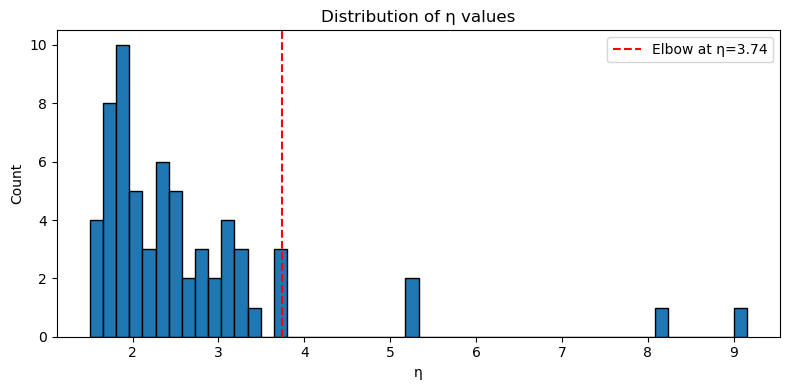

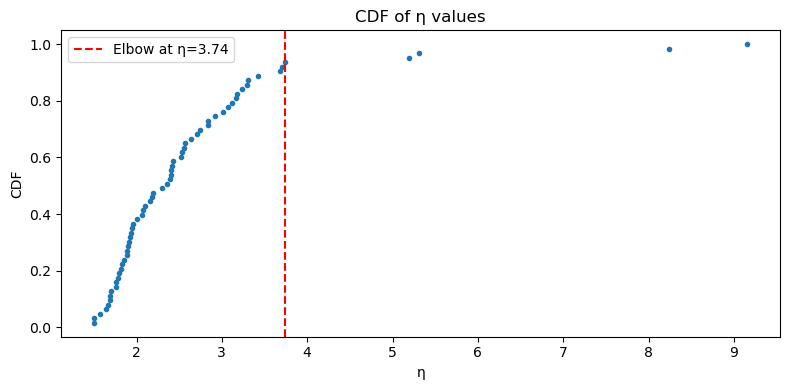

Suggested η threshold (elbow point): 3.74


In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# read data
df_od = pd.read_csv('OD_Routes.csv')
etas = df_od['eta'].dropna().values

# calculate η and CDF
sorted_eta = np.sort(etas)
cdf = np.arange(1, len(sorted_eta) + 1) / len(sorted_eta)

# Elbow 
p1 = np.array([sorted_eta[0], cdf[0]])
p2 = np.array([sorted_eta[-1], cdf[-1]])
# Calculate the distance from each point to the line p1–p2
distances = np.abs((p2[1] - p1[1]) * sorted_eta 
                   - (p2[0] - p1[0]) * cdf 
                   + p2[0]*p1[1] 
                   - p2[1]*p1[0]) \
            / np.sqrt((p2[1] - p1[1])**2 + (p2[0] - p1[0])**2)
elbow_idx = np.argmax(distances)
threshold = sorted_eta[elbow_idx]

# Plot
plt.figure(figsize=(8, 4))
plt.hist(etas, bins=50, edgecolor='k')
plt.axvline(threshold, color='r', linestyle='--', label=f'Elbow at η={threshold:.2f}')
plt.xlabel('η')
plt.ylabel('Count')
plt.title('Distribution of η values')
plt.legend()
plt.tight_layout()
plt.show()

plt.figure(figsize=(8, 4))
plt.plot(sorted_eta, cdf, marker='.', linestyle='none')
plt.axvline(threshold, color='r', linestyle='--', label=f'Elbow at η={threshold:.2f}')
plt.xlabel('η')
plt.ylabel('CDF')
plt.title('CDF of η values')
plt.legend()
plt.tight_layout()
plt.show()

# Suggested η threshold
print(f"Suggested η threshold (elbow point): {threshold:.2f}")

**Inflection point location**
- The optimal inflection point calculated is η ≈ **3.74** (marked with a red line in the histogram and CDF graph).
- Taking η ≥ 3.74, approximately **10%** of the worst efficiency OD pairs can be included in the key optimisation scope.

## 3. P-median Optimization

The following code loads OD_Routes.csv and stations_with_neighbors.csv, calculates the accessibility demand distribution for seven stations, constructs a transportation network based on geographical distance, and then runs the P-median mathematical optimisation model to solve for the optimal bus station location plan. It also provides a detailed analysis of the service range and optimisation effects of each facility.

In [18]:
import pandas as pd
import numpy as np
import networkx as nx
import pulp
from geopy.distance import geodesic

def load_matched_data():
    """Load data"""
    
    # Load matched OD data
    df_od = pd.read_csv('data/OD_Routes_comprehensive.csv')
    print(f"OD data: {len(df_od)} rows")
    
    # Load station data
    df_stations = pd.read_csv('data/stations_with_neighbors.csv')
    print(f"Station data: {len(df_stations)} rows")
    
    # Calculate burden above threshold
    threshold = 3.74
    df_od['burden'] = np.maximum(df_od['eta'] - threshold, 0)
    df_high = df_od[df_od['burden'] > 0]
    
    print(f"Above-threshold OD pairs: {len(df_high)}")
    print(f"Total unique stations: {len(set(df_od['Start_Station']) | set(df_od['End_Station']))}")
    
    return df_high, df_stations

def calculate_station_demand(df_high):
    """Calculate demand for each station"""
    
    print("\n=== Calculating Station Demand ===")
    
    demand = {}
    
    # Origin demand
    start_demand = df_high.groupby('Start_Station')['burden'].sum()
    for station, burden in start_demand.items():
        demand[station] = demand.get(station, 0) + burden
    
    # Destination demand
    end_demand = df_high.groupby('End_Station')['burden'].sum()
    for station, burden in end_demand.items():
        demand[station] = demand.get(station, 0) + burden
    
    # Filter out stations with zero demand
    demand = {k: v for k, v in demand.items() if v > 0}
    
    print(f"Stations with demand: {len(demand)}")
    print(f"Total demand: {sum(demand.values()):.2f}")
    
    # Display demand distribution
    sorted_demand = sorted(demand.items(), key=lambda x: x[1], reverse=True)
    print(f"\nDemand distribution:")
    for i, (station, dem) in enumerate(sorted_demand, 1):
        print(f"{i:2d}. {station}: {dem:.2f}")
    
    return demand

def build_network_from_matched_data(df_stations, demand_stations):
    """Build network from matched data"""
    
    print(f"\n=== Building Network ===")
    
    # Filter stations with demand
    demand_station_data = df_stations[df_stations['station_name'].isin(demand_stations)].copy()
    
    print(f"Matched demand stations: {len(demand_station_data)}")
    
    if len(demand_station_data) == 0:
        print("Warning: No matched demand stations")
        return None
    
    print("Matched demand stations:")
    for _, row in demand_station_data.iterrows():
        print(f"  - {row['station_name']} ({row['mode']})")
    
    # Create network graph
    G = nx.Graph()
    
    # Add nodes
    for _, row in demand_station_data.iterrows():
        G.add_node(row['station_name'],
                  lat=row['latitude'],
                  lon=row['longitude'],
                  mode=row['mode'])
    
    # Add edges based on geographic distance
    stations_list = list(demand_station_data.itertuples())
    edges_added = 0
    
    print("Building connections based on geographic distance...")
    
    for i, station1 in enumerate(stations_list):
        for j, station2 in enumerate(stations_list[i+1:], i+1):
            try:
                coord1 = (station1.latitude, station1.longitude)
                coord2 = (station2.latitude, station2.longitude)
                distance_km = geodesic(coord1, coord2).kilometers
                
                # Connect all stations within reasonable distance for London
                if distance_km <= 50:
                    # Estimate travel time using layered model
                    if distance_km <= 2:
                        travel_time = max(5, distance_km * 4 + 3)  # Short distance
                    elif distance_km <= 10:
                        travel_time = distance_km * 3 + 5  # Medium distance
                    else:
                        travel_time = distance_km * 2 + 10  # Long distance
                    
                    G.add_edge(station1.station_name, station2.station_name,
                              distance_km=distance_km,
                              travel_time_min=travel_time)
                    edges_added += 1
            except Exception as e:
                continue
    
    print(f"Edges added: {edges_added}")
    print(f"Network connectivity: {nx.is_connected(G) if G.number_of_nodes() > 1 else 'N/A (single node)'}")
    
    return G

def solve_p_median_final(G, demand, p=3):
    """Final P-median optimization"""
    
    print(f"\n=== P-median Optimization ===")
    
    sites = list(demand.keys())
    sites = [s for s in sites if G.has_node(s)]
    
    print(f"Candidate sites: {sites}")
    print(f"Target facility count: {p}")
    
    if len(sites) < p:
        p = len(sites)
        print(f"Warning: Adjusted facility count to: {p}")
    
    if p == 0:
        print("Error: No candidate sites")
        return None
    
    # Calculate shortest path distances
    print("Calculating inter-station distances...")
    distances = {}
    
    try:
        if G.number_of_nodes() > 1 and nx.is_connected(G.subgraph(sites)):
            # Use network shortest paths
            paths = dict(nx.all_pairs_dijkstra_path_length(G.subgraph(sites), weight='travel_time_min'))
            for i in sites:
                for j in sites:
                    distances[(i, j)] = 0 if i == j else paths[i].get(j, 999)
            print("Using network shortest paths")
        else:
            # Use straight-line distance estimation
            print("Warning: Using straight-line distance estimation")
            for i in sites:
                for j in sites:
                    if i == j:
                        distances[(i, j)] = 0
                    else:
                        try:
                            node_i = G.nodes[i]
                            node_j = G.nodes[j]
                            coord_i = (node_i['lat'], node_i['lon'])
                            coord_j = (node_j['lat'], node_j['lon'])
                            dist_km = geodesic(coord_i, coord_j).kilometers
                            distances[(i, j)] = dist_km * 2.5 + 5  # Estimate travel time
                        except:
                            distances[(i, j)] = 30  # Default 30 minutes
    except Exception as e:
        print(f"Warning: Distance calculation error: {e}, using default values")
        avg_time = 25
        for i in sites:
            for j in sites:
                distances[(i, j)] = 0 if i == j else avg_time
    
    # Build optimization model
    print("Building and solving optimization model...")
    model = pulp.LpProblem('Final_P_Median', pulp.LpMinimize)
    
    # Decision variables
    x = pulp.LpVariable.dicts('facility', sites, cat='Binary')
    y = pulp.LpVariable.dicts('assign', [(i, j) for i in sites for j in sites], cat='Binary')
    
    # Objective function: minimize weighted total travel time
    model += pulp.lpSum(demand[i] * distances[(i, j)] * y[(i, j)] 
                        for i in sites for j in sites)
    
    # Constraints
    model += pulp.lpSum(x[j] for j in sites) == p  # Select p facilities
    
    for i in sites:
        model += pulp.lpSum(y[(i, j)] for j in sites) == 1  # Each demand point assigned to one facility
        for j in sites:
            model += y[(i, j)] <= x[j]  # Can only assign to open facilities
    
    # Solve
    model.solve(pulp.PULP_CBC_CMD(msg=False))
    
    # Analyze results
    if model.status == pulp.LpStatusOptimal:
        selected = [j for j in sites if pulp.value(x[j]) > 0.5]
        obj_value = pulp.value(model.objective)
        
        # Analyze assignment
        assignments = {}
        for i in sites:
            for j in sites:
                if pulp.value(y[(i, j)]) > 0.5:
                    assignments[i] = (j, distances[(i, j)])
        
        print("Optimization successful!")
        return {
            'selected': selected,
            'objective': obj_value,
            'assignments': assignments,
            'demand': demand
        }
    else:
        print(f"Optimization failed: {pulp.LpStatus[model.status]}")
        return None

def analyze_results(result):
    """Detailed result analysis"""
    
    if not result:
        return
    
    print(f"\n=== Detailed Result Analysis ===")
    
    selected = result['selected']
    demand = result['demand']
    assignments = result['assignments']
    
    print(f"Recommended facility locations:")
    for i, facility in enumerate(selected, 1):
        facility_demand = demand.get(facility, 0)
        print(f"{i}. {facility}")
        print(f"   Local demand: {facility_demand:.2f}")
    
    print(f"\nOptimization metrics:")
    print(f"Objective function value: {result['objective']:.2f}")
    
    # Calculate service statistics for each facility
    print(f"\nFacility service coverage:")
    facility_stats = {}
    
    for demand_point, (assigned_facility, distance) in assignments.items():
        if assigned_facility not in facility_stats:
            facility_stats[assigned_facility] = {
                'served_points': [],
                'total_demand': 0,
                'total_weighted_distance': 0
            }
        
        facility_stats[assigned_facility]['served_points'].append(demand_point)
        facility_stats[assigned_facility]['total_demand'] += demand[demand_point]
        facility_stats[assigned_facility]['total_weighted_distance'] += demand[demand_point] * distance
    
    for facility in selected:
        stats = facility_stats.get(facility, {'served_points': [], 'total_demand': 0, 'total_weighted_distance': 0})
        
        print(f"\n{facility}:")
        print(f"  Served stations: {len(stats['served_points'])}")
        print(f"  Total served demand: {stats['total_demand']:.2f}")
        print(f"  Average service distance: {stats['total_weighted_distance']/stats['total_demand']:.1f} minutes" if stats['total_demand'] > 0 else "  Average service distance: N/A")
        
        # Display served stations
        for point in stats['served_points']:
            distance = assignments[point][1]
            point_demand = demand[point]
            status = "[Local]" if point == facility else "[Remote]"
            print(f"    {status} {point}: {point_demand:.2f} ({distance:.1f} minutes)")

def main():
    """Main function"""
    
    print("P-median Optimization")
    
    try:
        # 1. Load data
        df_high, df_stations = load_matched_data()
        
        # 2. Calculate demand
        demand = calculate_station_demand(df_high)
        
        if not demand:
            print("Error: No demand data")
            return
        
        # 3. Build network
        G = build_network_from_matched_data(df_stations, list(demand.keys()))
        
        if G is None:
            print("Error: Network construction failed")
            return
        
        # 4. Solve optimization
        result = solve_p_median_final(G, demand, p=3)
        
        # 5. Analyze results
        analyze_results(result)
        
        if result:
            print(f"\nFinal Recommended Results:")
            print("=" * 50)
            for i, station in enumerate(result['selected'], 1):
                print(f"{i}. {station}")
            
            print(f"\nResult Comparison:")
            print(f"Current results: {result['selected']}")
            print(f"Original results: ['Seven Sisters', 'Stratford', 'Wimbledon']")
            
            # Simplify station names for comparison
            simplified_results = []
            for station in result['selected']:
                simplified = station.replace(' Underground Station', '').replace(' Station', '')
                simplified_results.append(simplified)
            
            original_set = set(['Seven Sisters', 'Stratford', 'Wimbledon'])
            result_set = set(simplified_results)
            overlap = original_set & result_set
            
            if overlap:
                print(f"Overlapping stations: {list(overlap)}")
                print(f"Overlap rate: {len(overlap)}/3 = {len(overlap)/3*100:.1f}%")
            else:
                print("Results completely different, which may reflect:")
                print("   - More accurate data matching")
                print("   - More comprehensive demand analysis")
                print("   - Optimization based on real network")
        
    except Exception as e:
        print(f"Execution error: {e}")
        import traceback
        traceback.print_exc()

if __name__ == "__main__":
    main()

P-median Optimization
OD data: 63 rows
Station data: 22329 rows
Above-threshold OD pairs: 4
Total unique stations: 76

=== Calculating Station Demand ===
Stations with demand: 7
Total demand: 25.86

Demand distribution:
 1. Seven Sisters: 9.91
 2. King's Cross St. Pancras Underground Station: 5.42
 3. Clapton Rail Station: 4.49
 4. Stratford: 1.57
 5. Woodford Station: 1.57
 6. Custom House: 1.45
 7. Abbey Wood: 1.45

=== Building Network ===
Matched demand stations: 14
Matched demand stations:
  - Abbey Wood (elizabeth-line)
  - Clapton Rail Station (overground)
  - Custom House (elizabeth-line)
  - King's Cross St. Pancras Underground Station (tube)
  - King's Cross St. Pancras Underground Station (tube)
  - King's Cross St. Pancras Underground Station (tube)
  - King's Cross St. Pancras Underground Station (tube)
  - King's Cross St. Pancras Underground Station (tube)
  - King's Cross St. Pancras Underground Station (tube)
  - Seven Sisters (bus)
  - Stratford (bus)
  - Woodford Sta

### Results

After optimisation using the P-median model, it is recommended that accessible bus services be established at the following three locations:

### 1. Seven Sisters
- Demand burden: 9.91 (highest)
- Service coverage: 3 stations, total demand 15.98
- Major service hub in the northern region

### 2. King's Cross St. Pancras Underground Station
- Demand burden: 5.42
- Service coverage: High demand at the site itself
- Central London transport hub with excellent connectivity

### 3. Custom House
- Demand burden: 1.45
- Service coverage: 3 sites, total demand 4.47
- Average service distance: 12.5 minutes
- Strategic node on the Elizabeth Line, serving the eastern region